In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Nov 10 13:33:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install transformers

In [ ]:
!pip install -q -U watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.0 MB/s eta 0:00:00


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 7.34.0

numpy       : 2.0.2
pandas      : 2.2.2
torch       : 2.8.0+cu126
transformers: 4.57.1



# Making the necessary imports

In [ ]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data Preprocessing

In [ ]:
df = pd.read_csv('drive/MyDrive/Data/dataset_revisi.csv')
df.head()

,text,sentiment
0,Seblm jdi presiden hingga jdi presiden tekadny...,positive
1,Setiap pak presiden Prabowo bicara statement-s...,positive
2,"saya bangga punya presiden p prabowo bravo, ha...",positive
3,Masyarakat puas dengan memilih Bapak PRABOWO....,positive
4,Hebat pak Prabowo,positive


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(20)

,text,sentiment
7926,Anda dan kelompok sakit hati dan penyakit hati...,neutral
13888,"Harga barang makin nggak masuk akal, pemerinta...",negative
88,Baru kali Terharu dengar berita tentang presid...,positive
5396,Rencana untuk PPN 12% khusus untuk bawang mewa...,positive
1006,Alhamdulillah Bi Cheking ilang,positive
15794,regulasi soal layanan bpjs ini lebih banyak me...,negative
14913,Upaya pemerintah dalam pendidikan dianggap kur...,negative
12472,Beli barang mewah bebas ppn beli sembako malah...,negative
16012,lapangan kerja di daerah kami diabaikan sement...,negative
8612,Repost Kementerian Pertanian Selamat dan sukse...,neutral


In [ ]:
df = df[:20000]
len(df)

16017

In [ ]:
import re
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text)  # Menghapus link
    text = re.sub(r'<.*?>', '', text)  # Menghapus tag HTML
    text = re.sub(r'(&#\d+;|&[a-zA-Z]+;)', '', text)  # Menghapus entitas ASCII dan HTML
    # text = re.sub(r'[?@#]', '', text)  # Menghapus karakter ?, @, #
    text = re.sub(r'[?]', '', text)  # Menghapus tanda tanya (?)
    text = re.sub(r'@[\w]*', '', text)  # Menghapus @ beserta teksnya
    text = re.sub(r'#[\w]*', '', text)  # Menghapus # beserta teksnya
    text = re.sub(r'&#\d+;', '', text)  # Menghapus tag emoji dalam HTML (contoh: &#128512;)
    text = text.strip()  # Menghapus spasi berlebih
    return text

In [ ]:
df['text'] = df['text'].apply(clean_text)

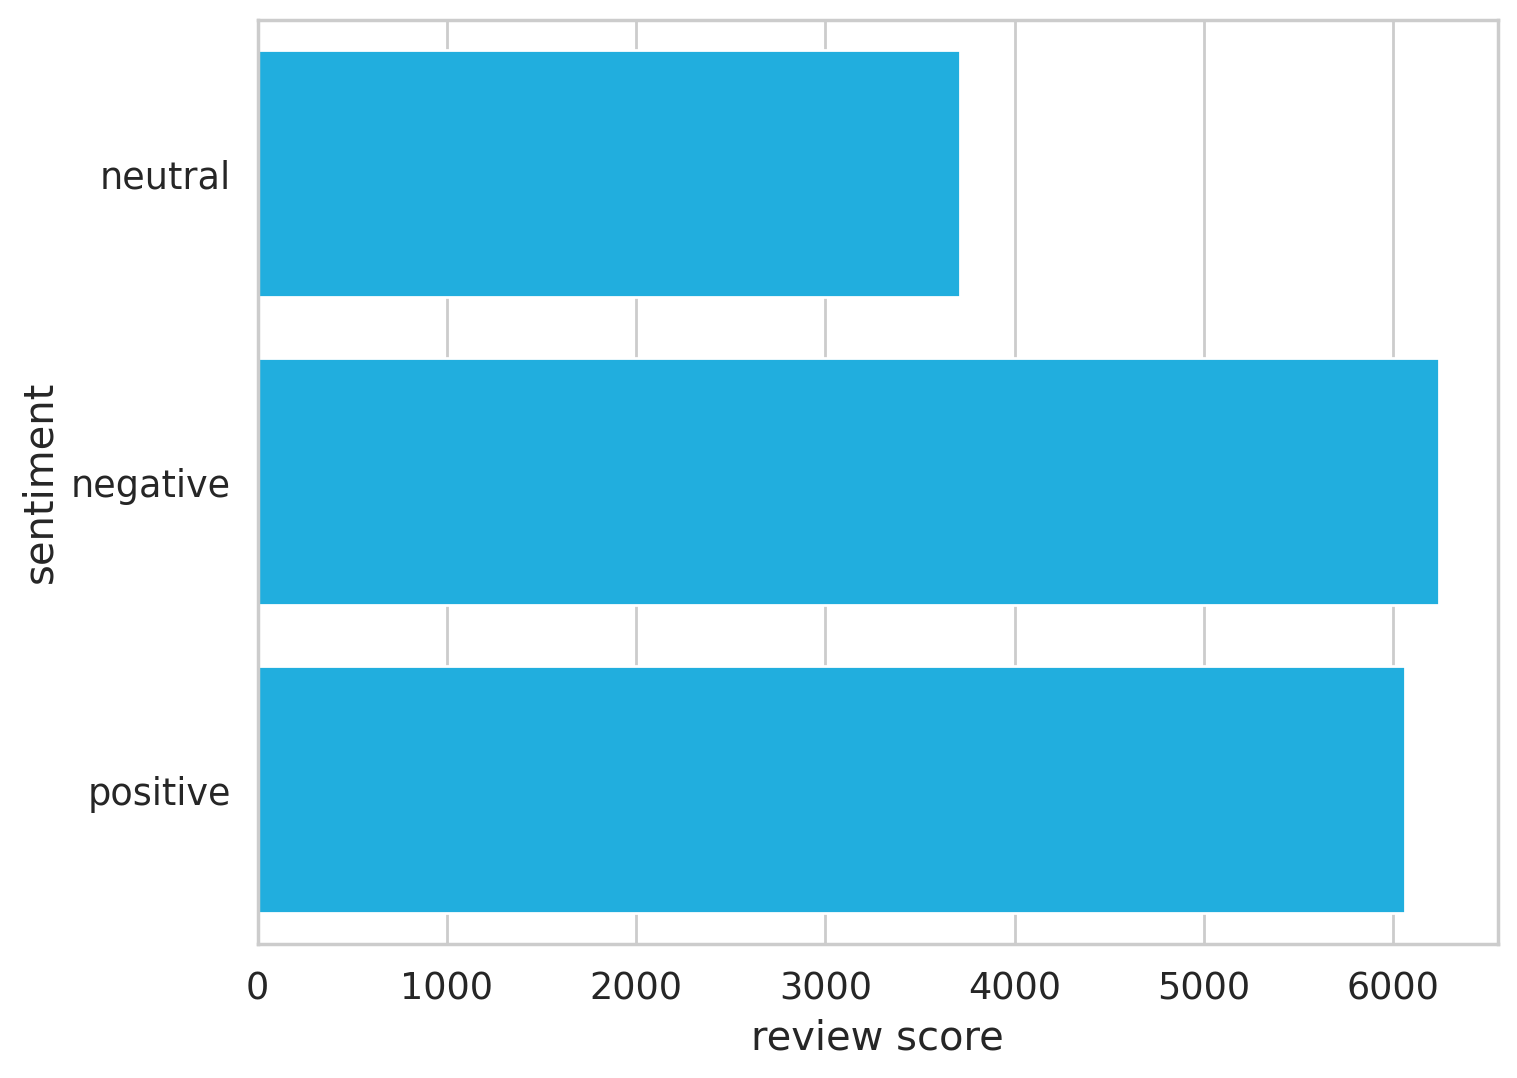

In [ ]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df.sentiment)
plt.xlabel('review score');

In [ ]:
def sentiment2label(sentiment):
    if sentiment == "positive":
        return 0
    elif sentiment == "negative":
        return 2
    else :
        return 1

df['sentiment'] = df['sentiment'].apply(sentiment2label)

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
2,6240
0,6064
1,3713


In [ ]:
class_names = ['positive', 'neutral', 'negative']

# Playing with XLNetTokenizer

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
input_txt = "Pemerintahan Prabowo dan Gibran"
# encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=False)
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, truncation=True, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, padding='max_length')

In [ ]:
print('input_ids : ',encodings['input_ids'])

input_ids :  tensor([[    5,  3612,  2196,   153,   751,  2643,  5769, 11525,   155,    17,
          4731,  3619,  2369,   262,     4,     3]])


In [ ]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])

['<pad>',
 '▁Pe',
 'mer',
 'in',
 'ta',
 'han',
 '▁Pra',
 'bow',
 'o',
 '▁',
 'dan',
 '▁Gi',
 'br',
 'an',
 '<sep>',
 '<cls>']

In [ ]:
type(encodings['attention_mask'])

torch.Tensor

In [ ]:
attention_mask = pad_sequences(encodings['attention_mask'], maxlen=512, dtype=torch.Tensor ,truncating="post",padding="post")

In [ ]:
attention_mask = attention_mask.astype(dtype = 'int64')
attention_mask = torch.tensor(attention_mask)
attention_mask.flatten()

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
encodings['input_ids']

tensor([[    5,  3612,  2196,   153,   751,  2643,  5769, 11525,   155,    17,
          4731,  3619,  2369,   262,     4,     3]])

# Checking the distribution  of token lengths

In [ ]:
token_lens = []

for txt in df['text']:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

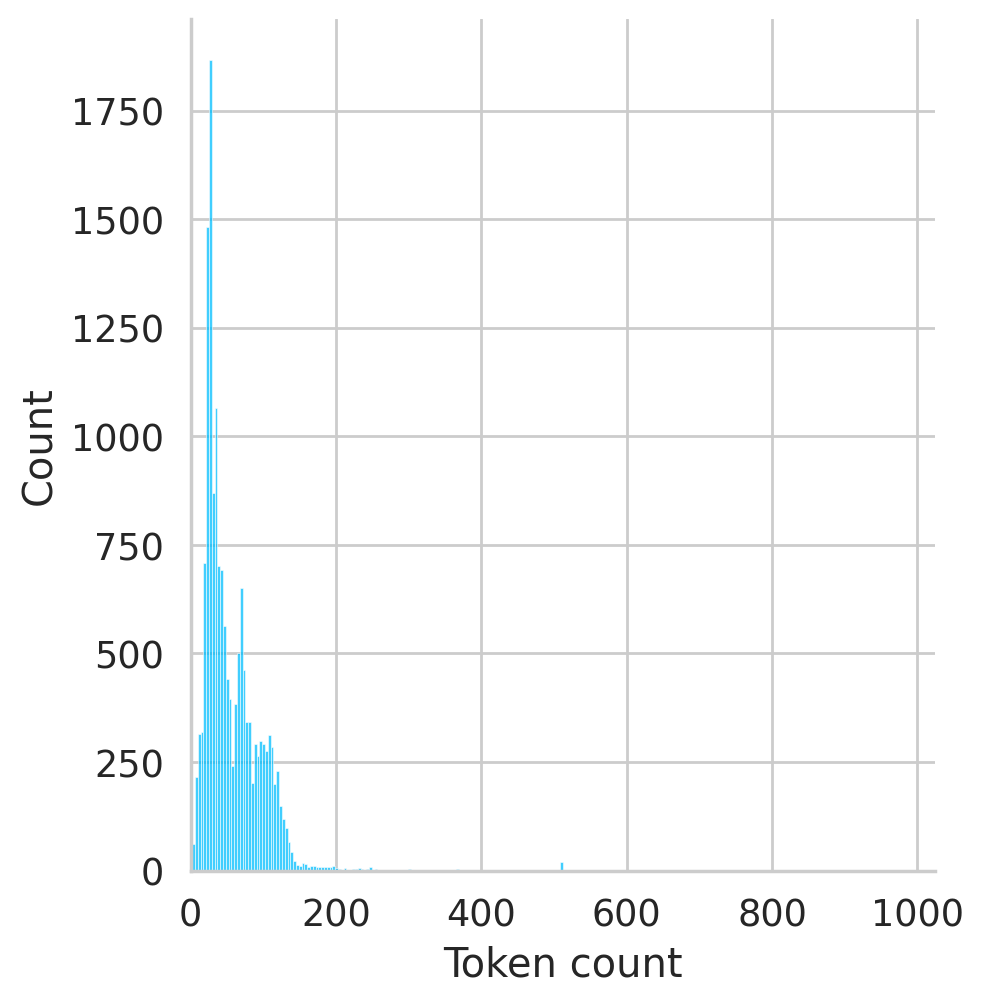

In [ ]:
sns.displot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 512

# Custom Dataset class

In [ ]:
class GovermentDataset(Dataset):

    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids)

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)

        return {
        'text': text,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
# class GovermentDataset(Dataset):

#     def __init__(self, text, targets, tokenizer, max_len):
#         self.text = text
#         self.targets = targets
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.text)

#     def __getitem__(self, item):
#         text = str(self.text[item])
#         target = self.targets[item]

#         encoding = self.tokenizer.encode_plus(
#         text,
#         add_special_tokens=True,
#         max_length=self.max_len,
#         return_token_type_ids=False,
#         pad_to_max_length=True, # Changed to True to enable automatic padding
#         return_attention_mask=True,
#         return_tensors='pt',
#         )

#         # Removed the manual padding since pad_to_max_length=True is used
#         # input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
#         # input_ids = input_ids.astype(dtype = 'int64')
#         # input_ids = torch.tensor(input_ids)
#         input_ids = encoding['input_ids'].squeeze(0) # Squeezing to remove extra dimension

#         # Removed the manual padding since pad_to_max_length=True is used
#         # attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
#         # attention_mask = attention_mask.astype(dtype = 'int64')
#         # attention_mask = torch.tensor(attention_mask)
#         attention_mask = encoding['attention_mask'].squeeze(0) # Squeezing to remove extra dimension

#         return {
#         'text': text,
#         'input_ids': input_ids,
#         'attention_mask': attention_mask, # Removed flatten
#         'targets': torch.tensor(target, dtype=torch.long)
#         }

In [ ]:
# df_train, df_test = train_test_split(df, test_size=0.5, random_state=101)
# df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)

# df_train, df_test = train_test_split(df, test_size=0.3, random_state=101)
# df_val, df_test = train_test_split(df_test, test_size=0.3, random_state=101)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_val, df_test = train_test_split(df_test, test_size=0.2, random_state=1)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((12813, 2), (2563, 2), (641, 2))

# Custom Dataloader

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GovermentDataset(
    texts=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # num_workers=4
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 4
# BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Loading the Pre-trained XLNet model for sequence classification from huggingface transformers

In [ ]:
from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 3)
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): XLNetSequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    

# Setting Hyperparameters

In [ ]:
EPOCHS = 5

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
# optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
# optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=3e-5)
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=3e-6)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

# Sanity check with one batch

In [ ]:
data = next(iter(val_data_loader))
data.keys()

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
# print(input_ids.reshape(8, 512).shape) # batch size x seq length
print(input_ids.reshape(4, 512).shape)
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 512])
torch.Size([4, 512])


In [ ]:
input_ids[0]

tensor([[    5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,  

In [ ]:
# outputs = model(input_ids.reshape(8, 512), token_type_ids=None, attention_mask=attention_mask, labels=targets)
# outputs

outputs = model(input_ids.reshape(4, 512), token_type_ids=None, attention_mask=attention_mask, labels=targets)
outputs

XLNetForSequenceClassificationOutput(loss=tensor(1.2266, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[-0.0744,  0.3147,  0.3936],
        [-0.1989,  0.2717,  0.2243],
        [-0.4755,  0.0507,  0.2748],
        [ 0.1348,  0.1233,  0.3829]], device='cuda:0',
       grad_fn=<AddmmBackward0>), mems=(tensor([[[ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252]],

        [[ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252]],

        [[ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ...

In [ ]:
type(outputs[0])

torch.Tensor

# Defining the training step function

In [ ]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0

    for d in data_loader:
        # Get the actual batch size
        batch_size = d["input_ids"].shape[0]
        # Reshape according to the actual batch size
        input_ids = d["input_ids"].reshape(batch_size, 512).to(device) # Reshape based on actual batch size
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

In [ ]:
# from sklearn import metrics

# def eval_model(model, data_loader, device, scheduler, n_examples):
#     """
#     Evaluates the model on the given data loader.

#     Args:
#         model: The model to evaluate.
#         data_loader: The data loader to use for evaluation.
#         device: The device to use for evaluation.
#         scheduler: The learning rate scheduler.
#         n_examples: The number of examples in the data loader.

#     Returns:
#         A tuple containing the accuracy and loss of the model on the data loader.
#     """
#     model = model.eval()
#     losses = []
#     acc = 0
#     counter = 0

#     with torch.no_grad():
#         for d in data_loader:
#             # Get the actual batch size
#             batch_size = d["input_ids"].shape[0]
#             # Reshape according to the actual batch size
#             input_ids = d["input_ids"].reshape(batch_size, 512).to(device)
#             attention_mask = d["attention_mask"].to(device)
#             targets = d["targets"].to(device)

#             outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels=targets)
#             loss = outputs[0]
#             logits = outputs[1]

#             _, prediction = torch.max(outputs[1], dim=1)
#             targets = targets.cpu().detach().numpy()
#             prediction = prediction.cpu().detach().numpy()
#             accuracy = metrics.accuracy_score(targets, prediction)

#             acc += accuracy
#             losses.append(loss.item())
#             counter += 1

#     return acc / counter, np.mean(losses)

# Defining the evaluation function

In [ ]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0

    with torch.no_grad():
        for d in data_loader:
            # Get the actual batch size
            batch_size = d["input_ids"].shape[0]  # Get actual batch size
            # Reshape according to the actual batch size
            input_ids = d["input_ids"].reshape(batch_size, 512).to(device) # Reshape based on actual batch size
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

# Fine-tuning the pre-trained model

In [ ]:
%%time
import os

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device,
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname('/content/drive/My Drive/NLP/Sentiment Analysis Series/models/xlnet_model.bin'), exist_ok=True)
        torch.save(model.state_dict(), '/content/drive/My Drive/NLP/Sentiment Analysis Series/models/xlnet_model.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.7374082746628914 Train accuracy 0.6757178526841449
Val loss 0.605127196422271 Val accuracy 0.7771710868434738

Epoch 2/5
----------
Train loss 0.6066476995337315 Train accuracy 0.7762952559300874
Val loss 0.6340012782318343 Val accuracy 0.7947217888715549

Epoch 3/5
----------
Train loss 0.5936081126861965 Train accuracy 0.805165418227216
Val loss 0.6514717843790823 Val accuracy 0.8056422256890275

Epoch 4/5
----------
Train loss 0.5730236634950284 Train accuracy 0.821707240948814
Val loss 0.762406679248988 Val accuracy 0.8095423816952677

Epoch 5/5
----------
Train loss 0.5602738364504558 Train accuracy 0.8387952559300874
Val loss 0.7893910016395403 Val accuracy 0.8103224128965159

CPU times: user 2h 41min 24s, sys: 24.6 s, total: 2h 41min 49s
Wall time: 2h 44min 32s


# Evaluation of the fine-tuned model

In [ ]:
# model.load_state_dict(torch.load('/content/drive/My Drive/NLP/Sentiment Analysis Series/models/xlnet_model.bin'))

model.load_state_dict(torch.load('/content/drive/My Drive/NLP/Sentiment Analysis Series/models/xlnet_model.bin', weights_only=True))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.8245341614906833
Test Loss : 0.7534337385777408


In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["text"]
            # input_ids = d["input_ids"].reshape(4,512).to(device)
            # attention_mask = d["attention_mask"].to(device)
            # targets = d["targets"].to(device)

            # Get the actual batch size
            batch_size = d["input_ids"].shape[0]

            # Reshape based on the actual batch size
            input_ids = d["input_ids"].reshape(batch_size, 512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]

            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
# Jika hasil masih berupa tensor, ubah ke numpy agar bisa diolah
if isinstance(y_pred, torch.Tensor):
    y_pred = y_pred.cpu().numpy()
if isinstance(y_test, torch.Tensor):
    y_test = y_test.cpu().numpy()
if isinstance(y_pred_probs, torch.Tensor):
    y_pred_probs = y_pred_probs.cpu().numpy()

# Mapping label numerik ke label teks (ubah sesuai label kamu)
label_map = {0: 'positive', 1: 'neutral', 2: 'negative'}

# Buat DataFrame hasil prediksi
df_results = pd.DataFrame({
    'text': y_review_texts,
    'sentiment': [label_map[label] for label in y_test],
    'predicted': [label_map[label] for label in y_pred],
    'prob_positive': [float(p[0]) for p in y_pred_probs],
    'prob_neutral': [float(p[1]) for p in y_pred_probs],
    'prob_negative': [float(p[2]) for p in y_pred_probs],
})

# Simpan ke file CSV
df_results.to_csv('xlnet_test_predictions.csv', index=False, encoding='utf-8-sig')

print("File 'xlnet_test_predictions.csv' berhasil disimpan!")
print(df_results.head())

File 'xlnet_test_predictions.csv' berhasil disimpan!
                                                text sentiment predicted  \
0               Penegakan hukum tebang pilih banget.  negative  negative   
1  hasil survei litbang kompas menyebutkan kinerj...   neutral   neutral   
2  kabar baik nih sobat tvri lebih dari masyaraka...   neutral  negative   
3     KPK dilemahkan, makin bebas koruptor ngeluyur.  negative  negative   
4  Acara ini juga menjadi momentum untuk mengapre...   neutral   neutral   

   prob_positive  prob_neutral  prob_negative  
0       0.000054      0.000033       0.999913  
1       0.000227      0.999408       0.000365  
2       0.008406      0.007998       0.983596  
3       0.000043      0.000035       0.999922  
4       0.004596      0.995001       0.000402  


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names, zero_division=1))

              precision    recall  f1-score   support

    positive       0.83      0.90      0.86       248
     neutral       0.79      0.66      0.72       140
    negative       0.83      0.84      0.84       253

    accuracy                           0.82       641
   macro avg       0.82      0.80      0.81       641
weighted avg       0.82      0.82      0.82       641



In [ ]:
cm = confusion_matrix(y_test, y_pred)

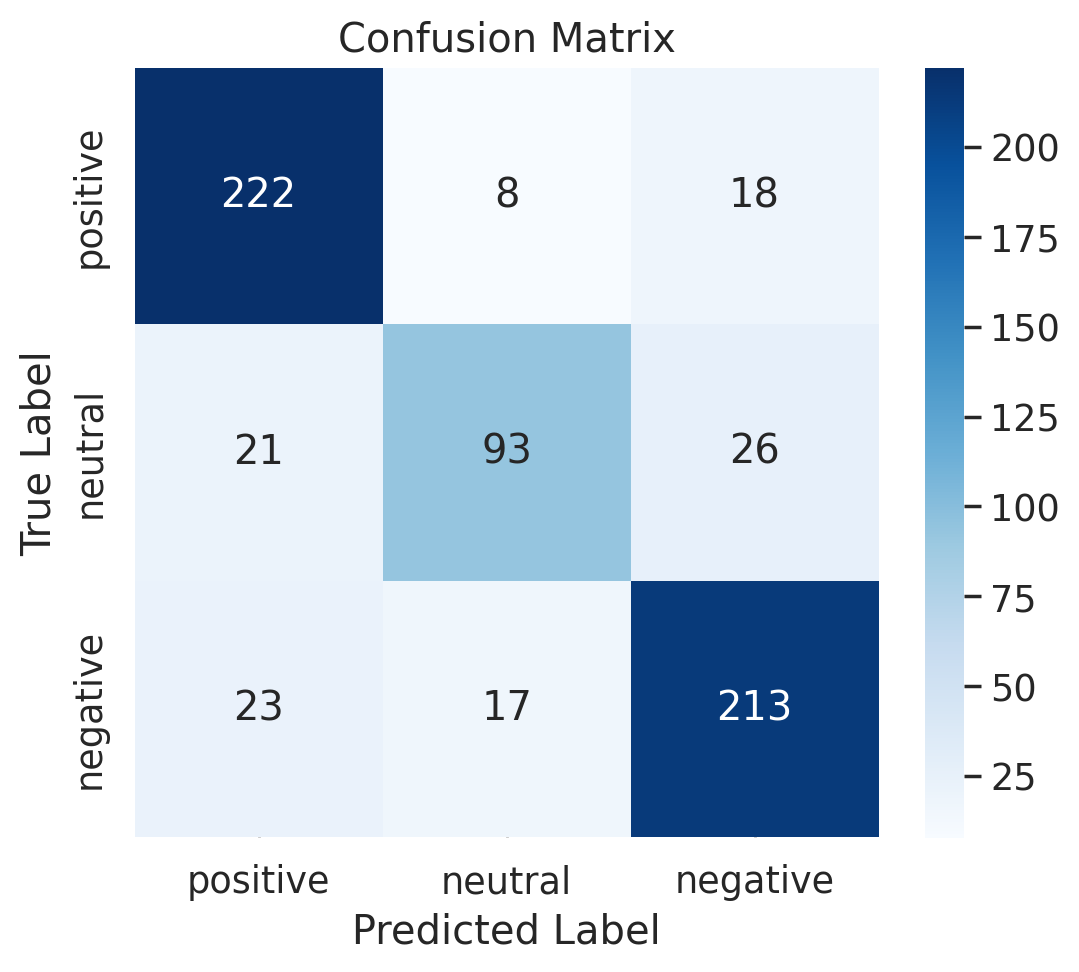

In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Nama label (Netral, Positif, Negatif)
class_names = ['positive', 'neutral', 'negative']
plot_confusion_matrix(cm, class_names)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.83      0.90      0.86       248
     neutral       0.79      0.66      0.72       140
    negative       0.83      0.84      0.84       253

    accuracy                           0.82       641
   macro avg       0.82      0.80      0.81       641
weighted avg       0.82      0.82      0.82       641



# Custom prediction function on raw text

In [ ]:
def predict_sentiment(text):
    review_text = text

    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids)

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask)

    input_ids = input_ids.reshape(1,512).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print("Neutral score:", probs[0])
    print("Positive score:", probs[1])
    print("Negative score:", probs[2])
    print(f'Review Text: {review_text}')
    print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
def predict_sentiment(text):
    model.eval()

    encoded_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs[0][0]
    probs = F.softmax(logits, dim=-1).cpu().numpy().tolist()

    # Sesuaikan urutan label dengan saat training
    labels = ['positive', 'neutral', 'negative']  # atau ['Negatif', 'Netral', 'Positif'] jika urutannya berbeda

    for label, score in zip(labels, probs):
        print(f"{label} score: {score:.4f}")

    predicted_index = int(np.argmax(probs))
    threshold = 0.6
    if probs[2] > threshold:
      sentiment = "Negative"
    elif probs[1] > threshold:
      sentiment = "Positive"
    elif probs[0] > 0.5:
      sentiment = "Neutral"
    else:
      sentiment = "Uncertain"

    print(f"\nReview Text: {text}")
    print(f"Sentiment  : {labels[predicted_index]}")

In [ ]:
text = "Pemerintahan Prabowo dan Gibran membawa angin segar bagi Indonesia dengan kebijakan inovatif yang fokus pada kemajuan ekonomi, pendidikan, dan kesejahteraan rakyat."
predict_sentiment(text)

positive score: 0.9996
neutral score: 0.0003
negative score: 0.0001

Review Text: Pemerintahan Prabowo dan Gibran membawa angin segar bagi Indonesia dengan kebijakan inovatif yang fokus pada kemajuan ekonomi, pendidikan, dan kesejahteraan rakyat.
Sentiment  : positive


In [ ]:
text = "Program pemerintah belum berjalan sesuai janji. Masyarakat kecewa karena visi belum terlihat nyata."
predict_sentiment(text)

positive score: 0.0492
neutral score: 0.0048
negative score: 0.9460

Review Text: Program pemerintah belum berjalan sesuai janji. Masyarakat kecewa karena visi belum terlihat nyata.
Sentiment  : negative


In [ ]:
text = "Apakah kinerja 100 hari Pemerintahan Prabowo dan Gibran sesuai dengan visi dan misinya?"
predict_sentiment(text)

positive score: 0.0069
neutral score: 0.9866
negative score: 0.0065

Review Text: Apakah kinerja 100 hari Pemerintahan Prabowo dan Gibran sesuai dengan visi dan misinya?
Sentiment  : neutral


# Pytorch

In [ ]:
from transformers import XLNetForSequenceClassification, XLNetTokenizer

# Misal: setelah fine-tuning XLNet
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

# torch.save(model.state_dict(), "saved_xlnet//pytorch_model.bin")
# model.config.to_json_file("saved_xlnet//config.json")
# tokenizer.save_pretrained("saved_xlnet//")

# Simpan model dan tokenizer
model.save_pretrained("saved_xlnet/")
tokenizer.save_pretrained("saved_xlnet/")

In [ ]:
torch.save(model.state_dict(), "saved_xlnet/pytorch_model.bin")

In [ ]:
import os
print("Isi folder test_bert:", os.listdir("saved_xlnet/"))

In [ ]:
from transformers import XLNetForSequenceClassification, XLNetConfig
import torch

# Buat konfigurasi baru dengan 3 label
config = XLNetConfig.from_pretrained("xlnet-base-cased")
config.num_labels = 3

# Buat model dengan config yang sudah dimodifikasi
model = XLNetForSequenceClassification(config)

# Load bobot hasil training
model.load_state_dict(torch.load('/content/drive/My Drive/NLP/Sentiment Analysis Series/models/xlnet_model.bin', map_location='cpu'))

# Cek ulang
print(model.config.num_labels)  # HARUS 3


config.id2label = {
    "0": "positive",
    "1": "neutral",
    "2": "negative"
}
config.label2id = {
    "positive": 0,
    "neutral": 1,
    "negative": 2
}

In [ ]:
config.save_pretrained("/content/drive/My Drive/NLP/Sentiment Analysis Series/models/xlnet_model_fixed")

In [ ]:
print("Jumlah label:", model.config.num_labels)

print("id2label:", model.config.id2label)
print("label2id:", model.config.label2id)